AI 期末作業 - Moving Average Baseline 模型
-------------------------------------
此腳本實作移動平均基準模型，作為 Seq2Seq 模型的比較對象。
使用與其他模型完全相同的資料切分邏輯 (40/10/25 天) 和評估指標。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# 設定中文字型支援
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

import os

1. 參數設定 (與其他模型一致)

In [3]:
DATA_PATH = "../data/task1_dataset_kotae.csv"
MODEL_SAVE_DIR = "../models"
LOG_SAVE_PATH = f"{MODEL_SAVE_DIR}/eval_log_baseline_ma.txt"

# 序列長度設定 (與 Seq2Seq 模型一致)
INPUT_SEQ_LEN = 144   # 輸入過去 72 小時 (用於計算移動平均)
OUTPUT_SEQ_LEN = 48   # 預測未來 24 小時

# 資料切分設定 (與其他模型一致)
TRAIN_DAYS = 40
VAL_DAYS = 10
TEST_DAYS = 25
TOTAL_DAYS = 75

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

2. 資料處理 (與其他模型相同邏輯)

In [4]:
def load_and_preprocess_data(path):
    print("Loading raw data...")
    raw_df = pd.read_csv(path)
    
    # 聚合計算人數
    print("Aggregating data to calculate 'number of people'...")
    df = raw_df.groupby(['d', 't', 'x', 'y']).size().reset_index(name='number of people')
    print(f"Aggregated data shape: {df.shape}")
    
    # --- A. 自動生成 Weekend 標籤 (K-Means) ---
    print("Generating 'is_weekend' labels using K-Means...")
    top_grid_idx = df.groupby(['x', 'y'])['number of people'].sum().idxmax()
    print(f"Base grid for clustering: {top_grid_idx}")
    
    base_df = df[(df['x'] == top_grid_idx[0]) & (df['y'] == top_grid_idx[1])].copy()
    pivot_matrix = base_df.pivot(index='d', columns='t', values='number of people').fillna(0)
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit(pivot_matrix)
    labels = kmeans.labels_
    
    c0_idx = np.where(labels == 0)[0]
    c1_idx = np.where(labels == 1)[0]
    
    if len(c0_idx) > 0 and len(c1_idx) > 0:
        avg_flow_0 = pivot_matrix.iloc[c0_idx, 16].mean()
        avg_flow_1 = pivot_matrix.iloc[c1_idx, 16].mean()
        weekend_label_cluster = 0 if avg_flow_0 < avg_flow_1 else 1
    else:
        weekend_label_cluster = 1 if len(c0_idx) < len(c1_idx) else 0

    day_is_weekend = [1 if l == weekend_label_cluster else 0 for l in labels]
    label_map = pd.DataFrame({'d': pivot_matrix.index, 'is_weekend': day_is_weekend})
    
    print(f"Weekday count: {len(label_map[label_map['is_weekend']==0])}")
    print(f"Weekend count: {len(label_map[label_map['is_weekend']==1])}")
    
    # --- B. 篩選前三大熱點 ---
    print("Selecting Top 3 locations...")
    top_3 = df.groupby(['x', 'y'])['number of people'].sum().nlargest(3).reset_index()[['x', 'y']]
    result_df = pd.merge(df, top_3, on=['x', 'y'], how='inner')
    result_df = pd.merge(result_df, label_map, on='d', how='left')
    
    # --- C. 標準化 ---
    scaler = MinMaxScaler()
    result_df['number_scaled'] = scaler.fit_transform(result_df[['number of people']])
    
    return result_df, scaler

3. Moving Average 預測函數

In [5]:
def moving_average_predict(input_sequence, output_len, window_size=48):
    """
    使用移動平均來預測未來值
    
    Args:
        input_sequence: 輸入序列 (shape: [seq_len])
        output_len: 要預測的時間步數
        window_size: 移動平均窗口大小 (預設48 = 24小時)
    
    Returns:
        predictions: 預測序列 (shape: [output_len])
    """
    predictions = []
    
    # 複製輸入序列作為工作序列
    working_seq = list(input_sequence)
    
    for _ in range(output_len):
        # 取最後 window_size 個值的平均
        if len(working_seq) >= window_size:
            pred = np.mean(working_seq[-window_size:])
        else:
            pred = np.mean(working_seq)
        
        predictions.append(pred)
        working_seq.append(pred)  # 將預測值加入序列
    
    return np.array(predictions)

4. 建立測試序列 (與其他模型相同邏輯)

In [6]:
def create_test_sequences(df, group_by_cols, target_col, input_seq_len, output_seq_len):
    """
    建立測試序列，與 GridTimeSeriesDataset 邏輯完全一致
    """
    sequences = []
    
    grouped = df.groupby(group_by_cols)
    
    for _, group_df in grouped:
        group_df = group_df.sort_values(['d', 't'])
        target_vals = group_df[target_col].values
        
        total_len = len(target_vals)
        
        for i in range(total_len - input_seq_len - output_seq_len + 1):
            input_seq = target_vals[i : i + input_seq_len]
            output_seq = target_vals[i + input_seq_len : i + input_seq_len + output_seq_len]
            
            sequences.append((input_seq, output_seq))
    
    return sequences

5. 主執行流程

Loading raw data...
Aggregating data to calculate 'number of people'...
Aggregated data shape: (39081336, 5)
Generating 'is_weekend' labels using K-Means...
Base grid for clustering: (np.int64(135), np.int64(77))
Weekday count: 49
Weekend count: 26
Selecting Top 3 locations...

--- 資料切分 ---
測試集天數: 50 ~ 74 (共 25 天)
測試樣本數: 3026

--- Moving Average 預測 ---

📈 Moving Average Baseline 評估結果 (測試集):
   MSE: 2803.1286
   RMSE: 52.9446
   MAE: 41.7438
📝 評估結果已儲存至 ../models/eval_log_baseline_ma.txt

測試集總數: 3026
正在搜尋人流波動明顯的樣本 (Max > 80)...
✅ 找到目標樣本 Index: 0 (最大人流: 100.00)


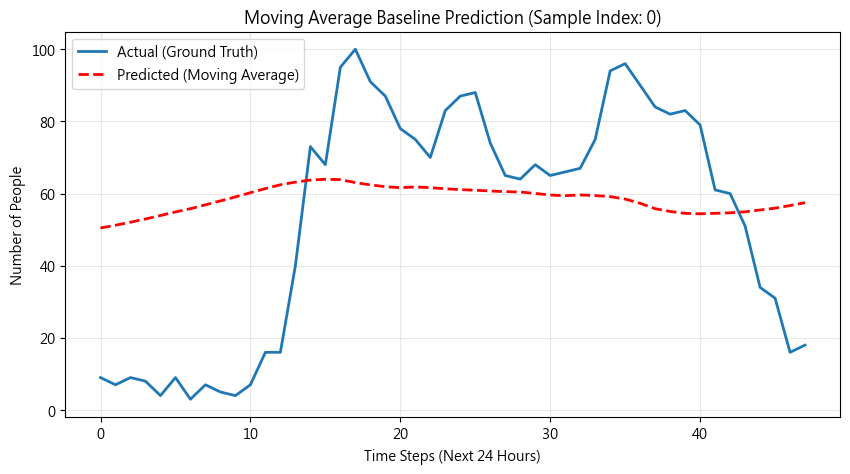

Result plot saved to ../models/prediction_result_baseline_ma.png


In [7]:
if __name__ == "__main__":
    
    # --- Step 1: 準備資料 ---
    df, scaler = load_and_preprocess_data(DATA_PATH)
    
    # --- Step 2: 切分資料 (與其他模型一致) ---
    test_df = df[df['d'] >= TRAIN_DAYS + VAL_DAYS]  # Day 50~74
    
    print(f"\n--- 資料切分 ---")
    print(f"測試集天數: {TRAIN_DAYS+VAL_DAYS} ~ {TOTAL_DAYS-1} (共 {TEST_DAYS} 天)")
    
    # --- Step 3: 建立測試序列 ---
    test_sequences = create_test_sequences(
        test_df,
        group_by_cols=['x', 'y'],
        target_col='number_scaled',
        input_seq_len=INPUT_SEQ_LEN,
        output_seq_len=OUTPUT_SEQ_LEN
    )
    
    print(f"測試樣本數: {len(test_sequences)}")
    
    if len(test_sequences) == 0:
        print("Error: 測試集為空！")
        exit()
    
    # --- Step 4: Moving Average 預測 ---
    print("\n--- Moving Average 預測 ---")
    
    all_preds = []
    all_targets = []
    
    for input_seq, target_seq in test_sequences:
        pred = moving_average_predict(input_seq, OUTPUT_SEQ_LEN, window_size=48)
        all_preds.append(pred)
        all_targets.append(target_seq)
    
    # 合併所有預測
    preds = np.concatenate(all_preds).reshape(-1, 1)
    targets = np.concatenate(all_targets).reshape(-1, 1)
    
    # 反標準化
    preds_original = scaler.inverse_transform(preds).flatten()
    targets_original = scaler.inverse_transform(targets).flatten()
    
    # --- Step 5: 計算評估指標 ---
    mse = mean_squared_error(targets_original, preds_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_original, preds_original)
    
    print(f"\n📈 Moving Average Baseline 評估結果 (測試集):")
    print(f"   MSE: {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    
    # --- Step 6: 儲存評估結果到 log 檔 ---
    with open(LOG_SAVE_PATH, 'w', encoding='utf-8') as f:
        f.write("=" * 50 + "\n")
        f.write("模型: Moving Average Baseline\n")
        f.write("=" * 50 + "\n")
        f.write(f"窗口大小: 48 (24小時)\n")
        f.write(f"輸入序列長度: {INPUT_SEQ_LEN}\n")
        f.write(f"預測序列長度: {OUTPUT_SEQ_LEN}\n")
        f.write(f"測試集: 後 25 天 (樣本數: {len(test_sequences)})\n")
        f.write("\n--- 測試集評估結果 ---\n")
        f.write(f"MSE:  {mse:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"MAE:  {mae:.4f}\n")
        f.write("=" * 50 + "\n")
    print(f"📝 評估結果已儲存至 {LOG_SAVE_PATH}")
    
    # --- Step 7: 視覺化 (與其他模型相同邏輯) ---
    # 智慧搜尋：在測試集中搜尋人流波動明顯的樣本
    total_len = len(test_sequences)
    print(f"\n測試集總數: {total_len}")
    
    target_sample_idx = 0
    found = False
    
    print("正在搜尋人流波動明顯的樣本 (Max > 80)...")
    
    for i in range(total_len):
        _, target_seq = test_sequences[i]
        temp_val = scaler.inverse_transform(target_seq.reshape(-1, 1))
        
        if temp_val.max() > 80:
            target_sample_idx = i
            print(f"✅ 找到目標樣本 Index: {i} (最大人流: {temp_val.max():.2f})")
            found = True
            break
    
    if not found:
        print("⚠️ 未找到 > 80 的樣本，將使用測試集的第一筆資料繪圖。")
    
    # 取得樣本進行預測
    sample_input, sample_target = test_sequences[target_sample_idx]
    sample_pred = moving_average_predict(sample_input, OUTPUT_SEQ_LEN, window_size=48)
    
    # 反標準化
    pred_orig = scaler.inverse_transform(sample_pred.reshape(-1, 1))
    target_orig = scaler.inverse_transform(sample_target.reshape(-1, 1))
    
    # 繪圖
    plt.figure(figsize=(10, 5))
    plt.plot(target_orig, label='Actual (Ground Truth)', linewidth=2)
    plt.plot(pred_orig, label='Predicted (Moving Average)', linestyle='--', color='red', linewidth=2)
    plt.title(f"Moving Average Baseline Prediction (Sample Index: {target_sample_idx})")
    plt.xlabel("Time Steps (Next 24 Hours)")
    plt.ylabel("Number of People")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{MODEL_SAVE_DIR}/prediction_result_baseline_ma.png")
    plt.show()
    print(f"Result plot saved to {MODEL_SAVE_DIR}/prediction_result_baseline_ma.png")
